In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Preprocessing

#### Data Cleaning

In [2]:
#Concatenate 2017-2022 Data to create the training dataset
file_names = [f"data/reshaped/{year}.csv" for year in range(2017, 2023)]
train_df = pd.concat([pd.read_csv(file_name) for file_name in file_names]).drop("Unnamed: 0", axis=1)
train_df.fillna(method='ffill', inplace=True)
train_df.head(5)

,Team,Name,Rating,Experience,Salary,Score,Home_Away,Opponent,Week
0,Packers,Aaron Rodgers,98,12,91000000,16.5,Home,81,1
1,Packers,Aaron Rodgers,98,12,91000000,18.5,Away,87,2
2,Packers,Aaron Rodgers,98,12,91000000,24.8,Home,74,3
3,Packers,Aaron Rodgers,98,12,91000000,23.1,Home,72,4
4,Packers,Aaron Rodgers,98,12,91000000,24,Away,91,5


In [3]:
#Look for bye week data
train_df["Home_Away"].value_counts()

Home_Away
Away    1644
Home    1643
Bye      201
Name: count, dtype: int64

In [4]:
#Drop bye week data
train_df = train_df[train_df["Home_Away"].isin(["Home", "Away"])]
train_df["Home_Away"].value_counts()

Home_Away
Away    1644
Home    1643
Name: count, dtype: int64

In [5]:
#Look at Fantasy Scores
train_df["Score"].value_counts()

Score
-       597
18       22
16.5     21
15.6     21
17.1     20
       ... 
35.8      1
41.3      1
0.9       1
39        1
40.9      1
Name: count, Length: 401, dtype: int64

In [6]:
'''
Drop Fantasy Scores less than 2
These games could have alow score due to injuries
In general the model should predict scores more than 2
'''
train_df['Score'] = pd.to_numeric(train_df['Score'], errors='coerce')
train_df = train_df.dropna(subset=['Score'])
train_df = train_df[train_df['Score'] > 2]
train_df["Score"].value_counts()

Score
18.0    22
16.5    21
15.6    21
17.1    20
17.5    20
        ..
32.2     1
36.0     1
38.5     1
40.1     1
40.9     1
Name: count, Length: 367, dtype: int64

#### Data Analysis

In [7]:
#Dataset for a specific player
train_df[train_df['Name'] == 'Tom Brady']

,Team,Name,Rating,Experience,Salary,Score,Home_Away,Opponent,Week
493,Patriots,Tom Brady,99,17,42500000,10.7,Home,90,1
494,Patriots,Tom Brady,99,17,42500000,30.8,Away,90,2
495,Patriots,Tom Brady,99,17,42500000,35.7,Home,86,3
496,Patriots,Tom Brady,99,17,42500000,20.5,Home,84,4
497,Patriots,Tom Brady,99,17,42500000,12.6,Away,81,5
...,...,...,...,...,...,...,...,...,...
625,Buccaneers,Tom Brady,97,22,1120000,12.1,Away,98,14
626,Buccaneers,Tom Brady,97,22,1120000,18.6,Home,89,15
627,Buccaneers,Tom Brady,97,22,1120000,13.3,Away,67,16
628,Buccaneers,Tom Brady,97,22,1120000,37.7,Home,84,17


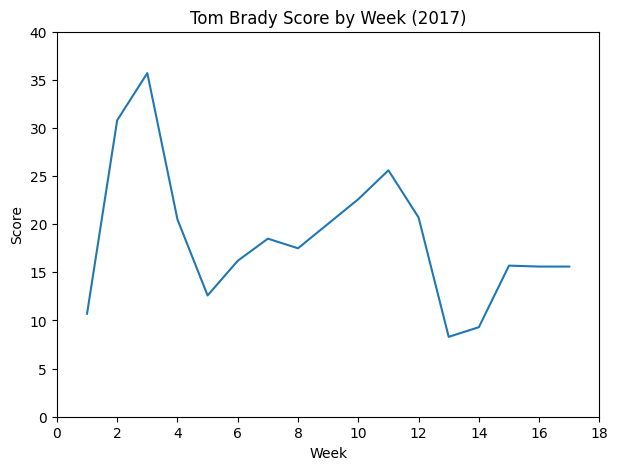

In [8]:
#Plot Tom Brady Fantasy Score in 2017
tom_brady = train_df[train_df['Name'] == 'Tom Brady'].head(16)
tom_brady['Week'] = pd.to_numeric(tom_brady['Week'])
tom_brady['Score'] = pd.to_numeric(tom_brady['Score'])
plt.figure(figsize=(7, 5))
plt.plot(tom_brady['Week'], tom_brady['Score'])
plt.title('Tom Brady Score by Week (2017)')
plt.xlabel('Week')
plt.ylabel('Score')
plt.ylim(0,40)
plt.xlim(0,18)
plt.show()


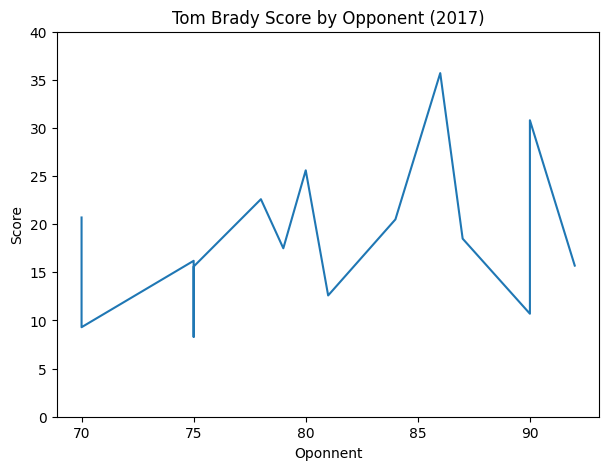

In [9]:
#Plot the relationship of the opponent rating and Fantasy Score
tom_brady['Opponent'] = pd.to_numeric(tom_brady['Opponent'])
tom_brady['Score'] = pd.to_numeric(tom_brady['Score'])
tom_brady = tom_brady.sort_values(by='Opponent')
plt.figure(figsize=(7, 5))
plt.plot(tom_brady['Opponent'], tom_brady['Score'])
plt.title('Tom Brady Score by Opponent (2017)')
plt.xlabel('Oponnent')
plt.ylabel('Score')
plt.ylim(0,40)
plt.show()

In [10]:
#Remove unnessecary columns
train_df = train_df.drop(columns=["Team", "Name"])
train_df

,Rating,Experience,Salary,Score,Home_Away,Opponent,Week
0,98,12,91000000,16.5,Home,81,1
1,98,12,91000000,18.5,Away,87,2
2,98,12,91000000,24.8,Home,74,3
3,98,12,91000000,23.1,Home,72,4
4,98,12,91000000,24.0,Away,91,5
...,...,...,...,...,...,...,...
673,73,1,12230000,19.4,Home,90,8
674,73,1,12230000,10.6,Home,91,9
676,73,1,12230000,5.7,Away,90,11
680,73,1,12230000,20.4,Home,81,15


In [11]:
#Encode Home_Away column
train_df['Home_Away'] = train_df['Home_Away'].map({'Home': 1, 'Away': 0})
train_df

,Rating,Experience,Salary,Score,Home_Away,Opponent,Week
0,98,12,91000000,16.5,1,81,1
1,98,12,91000000,18.5,0,87,2
2,98,12,91000000,24.8,1,74,3
3,98,12,91000000,23.1,1,72,4
4,98,12,91000000,24.0,0,91,5
...,...,...,...,...,...,...,...
673,73,1,12230000,19.4,1,90,8
674,73,1,12230000,10.6,1,91,9
676,73,1,12230000,5.7,0,90,11
680,73,1,12230000,20.4,1,81,15


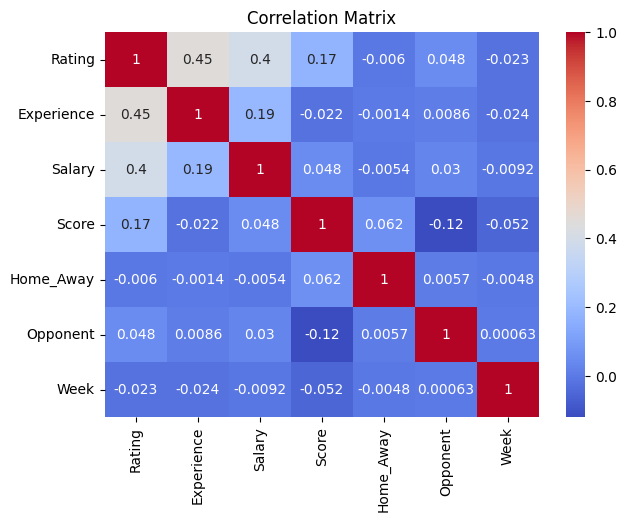

In [12]:
#Create correlation matrix to see the relationship between features
corr_matrix = train_df.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
#Split the training dataset
X = train_df.drop('Score', axis=1)
y = train_df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Clean the test dataset 
test_df = pd.read_csv("data/reshaped/2023.csv").drop(["Unnamed: 0", "Team", "Name"], axis=1)
test_df['Score'] = pd.to_numeric(test_df['Score'], errors='coerce')
test_df = test_df.dropna(subset=['Score'])
test_df = test_df[test_df['Score'] > 2]
test_df['Home_Away'] = test_df['Home_Away'].map({'Home': 1, 'Away': 0})
test_df

,Rating,Experience,Salary,Score,Home_Away,Opponent,Week
3,59,0,3830000,10.8,0,74,4
6,59,0,3830000,6.0,0,60,7
8,59,0,3830000,8.4,1,73,9
20,72,12,800000,23.5,0,74,3
36,70,0,3660000,21.9,1,87,1
...,...,...,...,...,...,...,...
669,69,2,12230000,19.2,1,92,4
670,69,2,12230000,9.6,0,69,5
671,69,2,12230000,10.9,1,95,6
673,69,2,12230000,12.1,0,73,8


In [15]:
#Split the test dataset
X_test = test_df.drop('Score', axis=1)
y_test = test_df["Score"]

## Linear Regression

In [16]:
#Lists to keep track of each model and mse
models = []
mse = []

#Create a basic linear regression pipeline
linear_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])
linear_param_grid = {
    'poly__degree': [1, 2, 3]
}

In [17]:
#Use grid search to find the best polynomial_degree
linear_grid_search = GridSearchCV(linear_pipeline, linear_param_grid, cv=5, verbose=1, n_jobs=-1)
linear_grid_search.fit(X_train, y_train)
print("Linear Regression Best parameters:", linear_grid_search.best_params_)
print("Linear Regression Best score:", linear_grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Linear Regression Best parameters: {'poly__degree': 1}
Linear Regression Best score: 0.05476903044167869


In [18]:
#Get MSE of the best model
linear_predictions = linear_grid_search.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_predictions)
models.append("Linear")
mse.append(linear_mse)
print("Linear Regression MSE:", linear_mse)

Linear Regression MSE: 48.85707788114773


In [19]:
#Create a ridge regression pipeline
ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
ridge_param_grid = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': np.logspace(-4, 4, 10)
}

In [20]:
#use grid search to find the best ridge_alpha and polynomial_degree
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, verbose=1, n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
print("Ridge Regression Best parameters:", ridge_grid_search.best_params_)
print("Ridge Regression Best score:", ridge_grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Ridge Regression Best parameters: {'poly__degree': 2, 'ridge__alpha': 166.81005372000558}
Ridge Regression Best score: 0.06117799649615017


In [21]:
#Get MSE of the best model
ridge_predictions = ridge_grid_search.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
models.append("Ridge")
mse.append(ridge_mse)
print("Ridge Regression MSE:", ridge_mse)

Ridge Regression MSE: 49.22630333736637


In [22]:
#Create a ridge regression pipeline
lasso_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])
lasso_param_grid = {
    'poly__degree': [1, 2, 3],
    'lasso__alpha': np.logspace(-4, 4, 10)
}

In [23]:
#use grid search to find the best lasso_alpha and polynomial_degree
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, verbose=1, n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
print("Lasso Best parameters:", lasso_grid_search.best_params_)
print("Lasso Best score:", lasso_grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Lasso Best parameters: {'lasso__alpha': 0.046415888336127774, 'poly__degree': 2}
Lasso Best score: 0.05994180946092007


In [24]:
#Get MSE of the best model
lasso_predictions = lasso_grid_search.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
models.append("Lasso")
mse.append(lasso_mse)
print("Lasso Regression MSE:", lasso_mse)

Lasso Regression MSE: 49.242534433880095


In [25]:
#Create pipeline to use polynomial features and sequential feature selection
inner_pipeline = make_pipeline(
    PolynomialFeatures(), 
    StandardScaler()
)
sfs_pipeline = Pipeline([
    ('prep', inner_pipeline),
    ('sfs', SequentialFeatureSelector(LinearRegression())),
    ('reg', LinearRegression())
])
sfs_param_grid = {
    'prep__polynomialfeatures__degree': [2, 3],
    'sfs__n_features_to_select': list(range(5, 16))
}

In [26]:
#Use grid search to calcuate the best parameters
sfs_grid_search = GridSearchCV(sfs_pipeline, sfs_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
sfs_grid_search.fit(X_train, y_train)
print("Best parameters:", sfs_grid_search.best_params_)
print("Best MSE score:", sfs_grid_search.best_score_)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
Best parameters: {'prep__polynomialfeatures__degree': 2, 'sfs__n_features_to_select': 13}
Best MSE score: -56.34729588063444


In [27]:
#Get the best MSE
sfs_predictions = sfs_grid_search.predict(X_test)
sfs_mse = mean_squared_error(y_test, sfs_predictions)
models.append("SFS")
mse.append(sfs_mse)
print("Sequential Feature Selection MSE:", sfs_mse)

Sequential Feature Selection MSE: 49.85663837319207


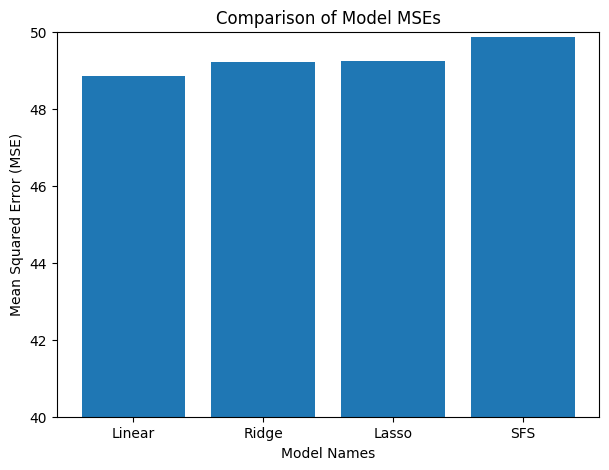

In [28]:
#Plot the MSE from each model to compare
plt.figure(figsize=(7, 5))
plt.bar(models, mse)
plt.xlabel('Model Names')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Model MSEs')
plt.xticks(models)
plt.ylim(40,50)
plt.show()

In [29]:
#Linear Regression model prediction on Jalen Hurts 2023
jalen_df = pd.read_csv("data/reshaped/2023.csv").drop(["Unnamed: 0", "Team"], axis=1)
jalen_df = jalen_df[jalen_df["Name"] == "Jalen Hurts"]
jalen_df['Score'] = pd.to_numeric(jalen_df['Score'], errors='coerce')
jalen_df = jalen_df.dropna(subset=['Score'])
jalen_df = jalen_df[jalen_df['Score'] > 2]
jalen_df['Home_Away'] = jalen_df['Home_Away'].map({'Home': 1, 'Away': 0})
jalen_df["Predicted_Score"] = linear_grid_search.predict(jalen_df.drop(["Score", "Name"], axis=1))
jalen_df

,Name,Rating,Experience,Salary,Score,Home_Away,Opponent,Week,Predicted_Score
270,Jalen Hurts,88,3,25550000,12.5,0,90,1,19.237012
271,Jalen Hurts,88,3,25550000,26.2,1,79,2,21.267432
272,Jalen Hurts,88,3,25550000,21.9,0,84,3,19.673914
273,Jalen Hurts,88,3,25550000,24.2,1,82,4,20.789299
274,Jalen Hurts,88,3,25550000,28.3,0,72,5,20.720840
275,Jalen Hurts,88,3,25550000,22.9,0,95,6,18.295855
276,Jalen Hurts,88,3,25550000,24.3,1,88,7,19.919593
277,Jalen Hurts,88,3,25550000,27.4,0,82,8,19.444452
278,Jalen Hurts,88,3,25550000,25.9,1,97,9,18.831436


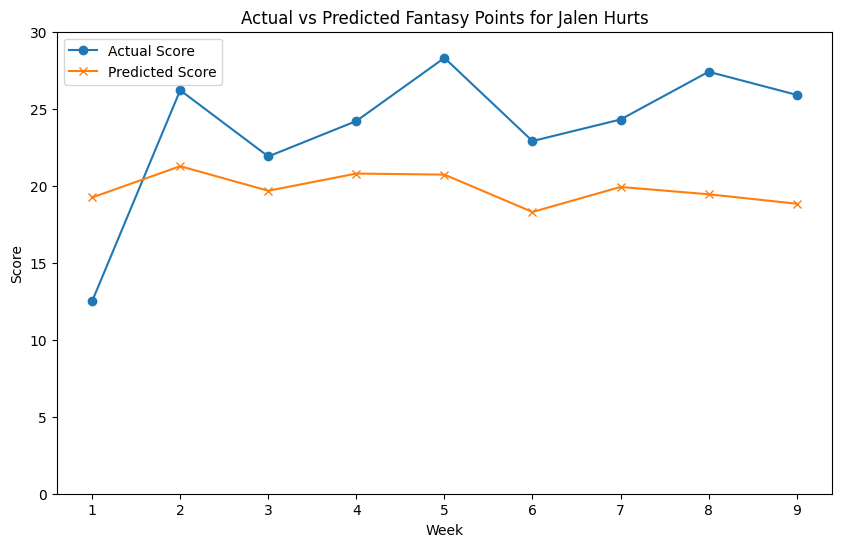

In [30]:
#Plot of Actual Score vs Predicted Score of Jalen Hurts 2023
plt.figure(figsize=(10, 6))
plt.plot(jalen_df['Week'], jalen_df['Score'], label='Actual Score', marker='o')
plt.plot(jalen_df['Week'], jalen_df['Predicted_Score'], label='Predicted Score', marker='x')
plt.xlabel('Week')
plt.ylabel('Score')
plt.title('Actual vs Predicted Fantasy Points for Jalen Hurts')
plt.ylim(0,30)
plt.legend()
plt.show()

In [31]:
#Linear Regression model prediction on Patrick Mahomes 2023
mahomes_df = pd.read_csv("data/reshaped/2023.csv").drop(["Unnamed: 0", "Team"], axis=1)
mahomes_df = mahomes_df[mahomes_df["Name"] == "Patrick Mahomes II"]
mahomes_df['Score'] = pd.to_numeric(mahomes_df['Score'], errors='coerce')
mahomes_df = mahomes_df.dropna(subset=['Score'])
mahomes_df = mahomes_df[mahomes_df['Score'] > 2]
mahomes_df['Home_Away'] = mahomes_df['Home_Away'].map({'Home': 1, 'Away': 0})
mahomes_df["Predicted_Score"] = linear_grid_search.predict(mahomes_df.drop(["Score", "Name"], axis=1))
mahomes_df

,Name,Rating,Experience,Salary,Score,Home_Away,Opponent,Week,Predicted_Score
504,Patrick Mahomes II,99,6,190400000,20.5,1,81,1,22.552590
505,Patrick Mahomes II,99,6,190400000,22.2,0,87,2,20.857401
506,Patrick Mahomes II,99,6,190400000,25.7,1,60,3,24.514552
507,Patrick Mahomes II,99,6,190400000,15.2,0,95,4,19.870915
508,Patrick Mahomes II,99,6,190400000,19.2,0,79,5,21.411084
509,Patrick Mahomes II,99,6,190400000,18.3,1,69,6,23.339834
510,Patrick Mahomes II,99,6,190400000,34.9,1,74,7,22.744920
511,Patrick Mahomes II,99,6,190400000,7.6,0,69,8,22.168108
512,Patrick Mahomes II,99,6,190400000,15.8,1,88,9,21.148410


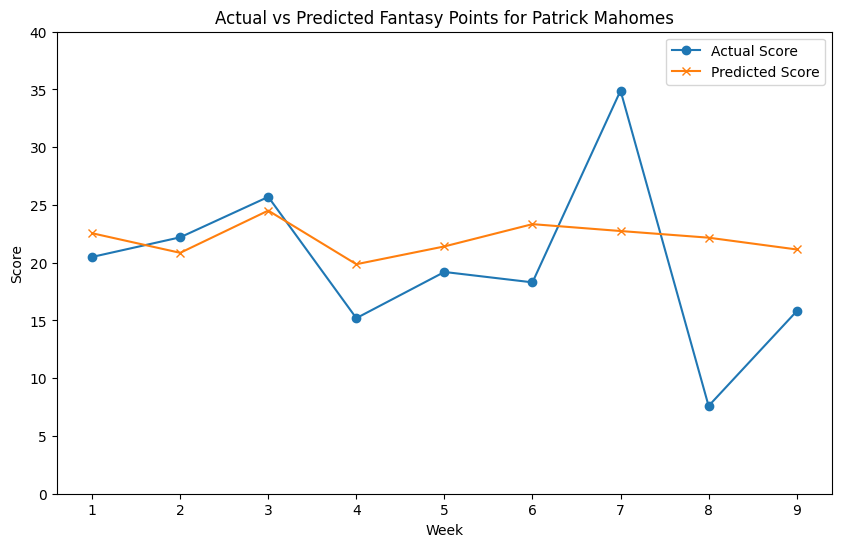

In [32]:
#Plot of Actual Score vs Predicted Score of Patrick Mahomes 2023
plt.figure(figsize=(10, 6))
plt.plot(mahomes_df['Week'], mahomes_df['Score'], label='Actual Score', marker='o')
plt.plot(mahomes_df['Week'], mahomes_df['Predicted_Score'], label='Predicted Score', marker='x')
plt.xlabel('Week')
plt.ylabel('Score')
plt.title('Actual vs Predicted Fantasy Points for Patrick Mahomes')
plt.ylim(0,40)
plt.legend()
plt.show()

In [33]:
#Find the coeeficents of each feature
best_model = linear_grid_search.best_estimator_
linear_model = best_model.named_steps['linear']
coefficients = linear_model.coef_
features = ["Rating", "Experience", "Salary", "Home_Away", "Opponent", "Week"]
print("Coefficients:", coefficients)

Coefficients: [ 0.          1.93935852 -0.99009361 -0.18723629  0.49930075 -0.87705542
 -0.439993  ]


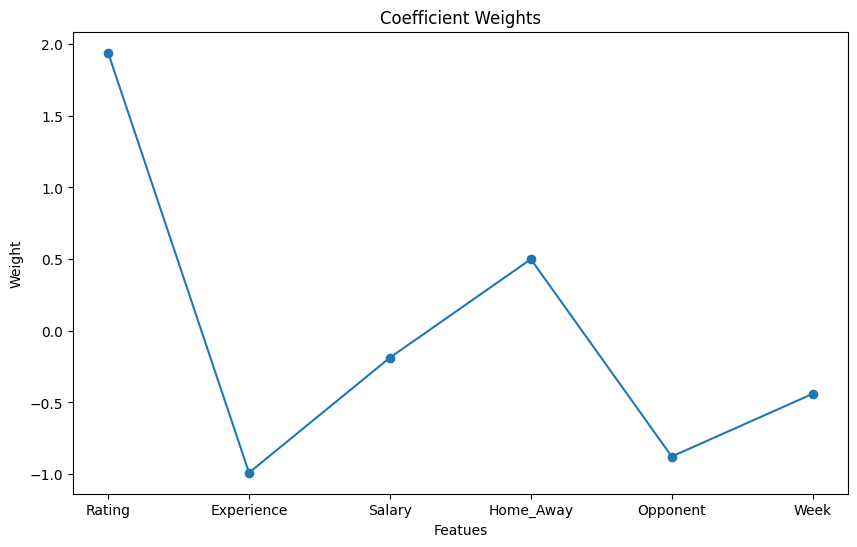

In [34]:
#Plot the coefficients to see how each feature affects the score
plt.figure(figsize=(10, 6))
plt.plot(features, coefficients[1:], marker='o')
plt.xlabel('Featues')
plt.ylabel('Weight')
plt.title('Coefficient Weights')
plt.show()

## Neural Network

In [35]:
#Scale training and test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
#List to store each model and MSE
nn_models = []
nn_mses = []

In [37]:
#Create model
tf.random.set_seed(42)
model1 = Sequential([Dense(3, activation = 'linear'),
                     Dense(6, activation = 'linear'),
                     Dense(3, activation = 'linear'),
                   Dense(1, activation = 'linear'),
                   ])
model1.compile(optimizer= Adam(learning_rate=0.01), loss = 'mse', metrics = ['mse'],)
model1.fit(X_train_scaled, y_train, epochs = 100, verbose = True)


Epoch 1/100


65/65 [==============================] - 1s 1ms/step - loss: 233.0822 - mse: 233.0822
Epoch 2/100
65/65 [==============================] - 0s 1ms/step - loss: 56.8192 - mse: 56.8192
Epoch 3/100
65/65 [==============================] - 0s 1ms/step - loss: 57.0327 - mse: 57.0327
Epoch 4/100
65/65 [==============================] - 0s 1ms/step - loss: 56.9079 - mse: 56.9079
Epoch 5/100
65/65 [==============================] - 0s 1ms/step - loss: 57.0847 - mse: 57.0847
Epoch 6/100
65/65 [==============================] - 0s 1ms/step - loss: 57.5779 - mse: 57.5779
Epoch 7/100
65/65 [==============================] - 0s 1ms/step - loss: 57.3293 - mse: 57.3293
Epoch 8/100
65/65 [==============================] - 0s 1ms/step - loss: 57.0419 - mse: 57.0419
Epoch 9/100
65/65 [==============================] - 0s 1ms/step - loss: 56.7824 - mse: 56.7824
Epoch 10/100
65/65 [==============================] - 0s 1ms/step - loss: 57.0610 - mse: 57.0610
Epoch 11/100
65/65 [==============

In [38]:
#Get MSE of model 1
m1_pred = model1.predict(X_test_scaled)
m1_mse = mean_squared_error(y_test, m1_pred)
nn_models.append("Model 1")
nn_mses.append(m1_mse)
print("100 Width MSE:", m1_mse)

9/9 [==============================] - 0s 1ms/step
100 Width MSE: 48.99159322293863


In [39]:
#Create model 2
model2 = Sequential([
                   Dense(2, activation = 'sigmoid'),
                   Dense(1, activation = 'linear'),
                   ])
model2.compile(optimizer= Adam(learning_rate=0.01), loss = 'mse', metrics = ['mse'],)
model2.fit(X_train_scaled, y_train, epochs = 100, verbose = True)

Epoch 1/100
65/65 [==============================] - 1s 1ms/step - loss: 362.3382 - mse: 362.3382
Epoch 2/100
65/65 [==============================] - 0s 1ms/step - loss: 312.9529 - mse: 312.9529
Epoch 3/100
65/65 [==============================] - 0s 1ms/step - loss: 258.8471 - mse: 258.8471
Epoch 4/100
65/65 [==============================] - 0s 1ms/step - loss: 204.4868 - mse: 204.4868
Epoch 5/100
65/65 [==============================] - 0s 1ms/step - loss: 161.4022 - mse: 161.4022
Epoch 6/100
65/65 [==============================] - 0s 1ms/step - loss: 130.1334 - mse: 130.1334
Epoch 7/100
65/65 [==============================] - 0s 1ms/step - loss: 107.6937 - mse: 107.6937
Epoch 8/100
65/65 [==============================] - 0s 1ms/step - loss: 91.7754 - mse: 91.7754
Epoch 9/100
65/65 [==============================] - 0s 1ms/step - loss: 80.6303 - mse: 80.6303
Epoch 10/100
65/65 [==============================] - 0s 1ms/step - loss: 73.0424 - mse: 73.0424
Epoch 11/100
65/65 [=====

In [40]:
#Get MSE of model 2
m2_pred = model2.predict(X_test_scaled)
m2_mse = mean_squared_error(y_test, m2_pred)
nn_models.append("Model 2")
nn_mses.append(m2_mse)
print("100 Width MSE:", m2_mse)

9/9 [==============================] - 0s 999us/step
100 Width MSE: 48.46577788013497


In [41]:
#Create model 3
model3 = Sequential([
                   Dense(2, activation = 'sigmoid'),
                   Dense(1, activation = 'linear'),
                   Dense(268, activation = 'relu'),
                   Dense(64, activation='relu'),
                   Dense(32, activation = 'relu'),
                   Dense(1, activation = 'linear'),
                   ])
model3.compile(optimizer= Adam(learning_rate=0.0001), loss = 'mse', metrics = ['mse'],)
model3.fit(X_train_scaled, y_train, epochs = 1000, verbose = True)

Epoch 1/1000
65/65 [==============================] - 1s 2ms/step - loss: 372.8139 - mse: 372.8139
Epoch 2/1000
65/65 [==============================] - 0s 1ms/step - loss: 365.9628 - mse: 365.9628
Epoch 3/1000
65/65 [==============================] - 0s 1ms/step - loss: 351.9832 - mse: 351.9832
Epoch 4/1000
65/65 [==============================] - 0s 1ms/step - loss: 326.3598 - mse: 326.3598
Epoch 5/1000
65/65 [==============================] - 0s 1ms/step - loss: 284.4636 - mse: 284.4636
Epoch 6/1000
65/65 [==============================] - 0s 1ms/step - loss: 226.1186 - mse: 226.1186
Epoch 7/1000
65/65 [==============================] - 0s 1ms/step - loss: 160.5864 - mse: 160.5864
Epoch 8/1000
65/65 [==============================] - 0s 1ms/step - loss: 105.8779 - mse: 105.8779
Epoch 9/1000
65/65 [==============================] - 0s 1ms/step - loss: 76.0028 - mse: 76.0028
Epoch 10/1000
65/65 [==============================] - 0s 1ms/step - loss: 66.9038 - mse: 66.9038
Epoch 11/1000

In [42]:
#Get MSE of model 3
m3_pred = model3.predict(X_test_scaled)
m3_mse = mean_squared_error(y_test, m3_pred)
nn_models.append("Model 3")
nn_mses.append(m3_mse)
print("100 Width MSE:", m3_mse)

9/9 [==============================] - 0s 1ms/step
100 Width MSE: 48.62014212532014


In [43]:
#Create model 4

model4 = Sequential([
                   Dense(2, activation = 'linear'),
                   Dense(1, activation = 'sigmoid'),
                   Dense(268, activation = 'linear'),
                   Dense(32, activation = 'relu'),
                   Dense(1, activation = 'linear'),
                   ])
model4.compile(loss = 'mse', metrics = ['mse'],)
model4.fit(X_train_scaled, y_train, epochs = 175, verbose = True)


Epoch 1/175
65/65 [==============================] - 1s 1ms/step - loss: 262.3127 - mse: 262.3127
Epoch 2/175
65/65 [==============================] - 0s 1ms/step - loss: 74.0148 - mse: 74.0148
Epoch 3/175
65/65 [==============================] - 0s 1ms/step - loss: 62.2043 - mse: 62.2043
Epoch 4/175
65/65 [==============================] - 0s 1ms/step - loss: 60.0870 - mse: 60.0870
Epoch 5/175
65/65 [==============================] - 0s 1ms/step - loss: 58.5585 - mse: 58.5585
Epoch 6/175
65/65 [==============================] - 0s 1ms/step - loss: 57.9754 - mse: 57.9754
Epoch 7/175
65/65 [==============================] - 0s 1ms/step - loss: 57.6210 - mse: 57.6210
Epoch 8/175
65/65 [==============================] - 0s 1ms/step - loss: 57.3225 - mse: 57.3225
Epoch 9/175
65/65 [==============================] - 0s 1ms/step - loss: 57.0352 - mse: 57.0352
Epoch 10/175
65/65 [==============================] - 0s 1ms/step - loss: 56.9048 - mse: 56.9048
Epoch 11/175
65/65 [================

In [44]:
#Get MSE of model 4
m4_pred = model4.predict(X_test_scaled)
m4_mse = mean_squared_error(y_test, m4_pred)
nn_models.append("Model 4")
nn_mses.append(m4_mse)
print("100 Width MSE:", m4_mse)

9/9 [==============================] - 0s 1ms/step
100 Width MSE: 47.758858413242535


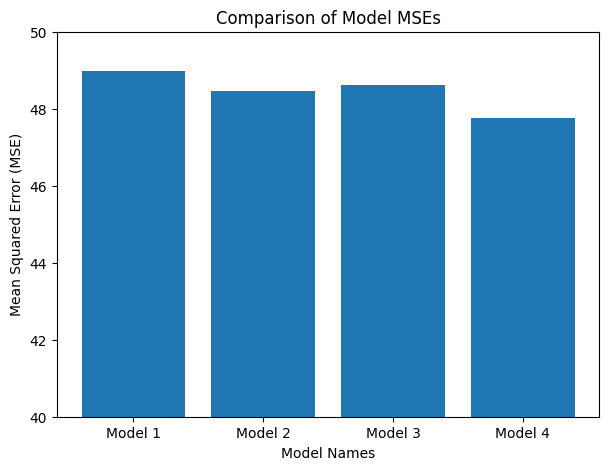

In [46]:
#Plot the MSE from each model to compare
plt.figure(figsize=(7, 5))
plt.bar(nn_models, nn_mses)
plt.xlabel('Model Names')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Model MSEs')
plt.xticks(nn_models)
plt.ylim(40,50)
plt.show()